In [1]:
import random
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from sklearn.metrics import accuracy_score
from typing import Optional, List

In [2]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [3]:
import cv2

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Matplotlib
plt.rcParams["figure.figsize"] = (13, 7)

cpu


In [5]:
resize = transforms.Resize((128, 128))
transform = transforms.Compose([
    transforms.ToTensor(),
    resize,
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

In [6]:
TRAIN_PATH = "C:/mini project/FastAI_ImageNet_v2/train"
TEST_PATH = "C:/mini project/FastAI_ImageNet_v2/val"

train_dataset = ImageFolder(root=TRAIN_PATH, transform=transform)
test_dataset = ImageFolder(root=TEST_PATH, transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


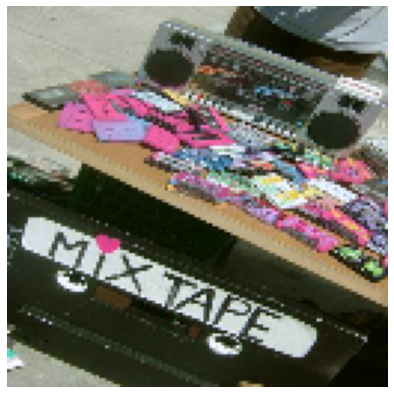

In [7]:
# Show example image from dataset

def show_image(image, normalized=True): 
    """
    Plots an image from a tensor.
    """
    if normalized: 
        image = inv_normalize(image)
    image = image.detach().cpu().permute(1, 2, 0)
    plt.imshow(image)
    plt.axis("off")
    
show_image(train_dataset[0][0])

In [8]:
from torchvision.models import vgg11

class CustomVGG(nn.Module): 
    BLOCKS = [0, 0, 0, 
              1, 1, 1,
              2, 2, 2, 2, 2,
              3, 3, 3, 3, 3,
              4, 4, 4, 4, 4]
    
    def __init__(self, num_out: int): 
        super().__init__()
        self.vgg = vgg11(pretrained=True)
        # Taken directly from source code: 
        # https://pytorch.org/vision/stable/_modules/torchvision/models/vgg.html#vgg11
        self.vgg.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_out)
        )
    
        self.vgg_layers = {}
        for layer, block_id in zip(self.vgg.features.children(), self.BLOCKS): 
            if block_id not in self.vgg_layers: 
                self.vgg_layers[block_id] = []
            self.vgg_layers[block_id].append(layer)
    
    def freeze_layers(self): 
        for name, layer in self.vgg.named_children(): 
            if name != "classifier":
                for param in layer.parameters():
                    param.require_grad = False
    
    def get_result_from_layer(self, x:torch.Tensor, block: int):
        """
        0-indexed
        """
        modules = []
        for block_id in range(block+1):
            modules.extend(self.vgg_layers[block_id])
        
        layer = nn.Sequential(*modules)
        result = layer(x)
        return result
                
    def forward(self, x): 
        return self.vgg(x)
    
model = CustomVGG(len(train_dataset.classes))
model.freeze_layers()
model.to(device)
optimizer = optim.AdamW(model.parameters())
criterion = nn.CrossEntropyLoss()

C:\Users\Sachin\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Sachin\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
#Visualization
# Creates a 4x4 
SQUARE_SIZE = 4 
# Determines how much of the heatmap is visible on superimposed image
HEATMAP_INTENSITY = 0.4 

def plot_visuals(model: nn.Module,
                 dataset: Dataset,
                 idx: int,
                 block:int, 
                 channel_seed:Optional[int]=None,
                 super_impose:bool=True,
                 channels:Optional[List]=None,
                 include_ori:bool=True): 
    """
    idx: ID of image from dataset to choose
    block: Which block to visualize from
    channel_seed: Determines which channels are showed
    channels: Force which channels to use
    """
    image = dataset[idx][0].unsqueeze(0).to(device)
    image_np = dataset[idx][0]
    image_np = inv_normalize(image_np)
    image_np = image_np.permute(1, 2, 0).numpy()

    vis = model.get_result_from_layer(image, block)
    vis = vis.detach().cpu().squeeze(0).numpy()
    np.random.seed(channel_seed)
    if channels is None:
        channels = list(np.random.choice(range(vis.shape[0]), size=SQUARE_SIZE**2, replace=False))
    if len(channels) < SQUARE_SIZE ** 2: 
        available = list(set(range(vis.shape[0])) - set(channels))
        additional = np.random.choice(available, size=(SQUARE_SIZE**2)-len(channels), replace=False)
        channels.extend(additional)
    
    if include_ori: 
        channels.insert(0, -1)
        channels.pop()
    
    fig, axs = plt.subplots(SQUARE_SIZE, SQUARE_SIZE, figsize=(15, 15))
    fig.suptitle(f"ID: {idx} block: {block}")
    for i in range(SQUARE_SIZE): 
        for j in range(SQUARE_SIZE): 
            channel = channels[(i*SQUARE_SIZE)+j]
            val = vis[channel, ...]
            if include_ori and channel == -1: 
                result = image_np
            elif super_impose:
                val = cv2.resize(val, (128, 128), interpolation = cv2.INTER_LINEAR)
                val = val / val.max()
                val = np.uint8(255 * val)
                val = cv2.applyColorMap(val, cv2.COLORMAP_JET)
                val = np.float64(val)/255
                result = (image_np * (1 - HEATMAP_INTENSITY)) + (HEATMAP_INTENSITY * val)
            else: 
                val = cv2.resize(val, (128, 128), interpolation = cv2.INTER_LINEAR)
                result = val
            axs[i][j].imshow(result, cmap="jet_r")
            axs[i][j].axis("off")
            axs[i][j].set_title(f"Channel {channel}")
    plt.tight_layout()
    plt.show()
    
def get_random_id(dataset): 
    np.random.seed(None)
    return np.random.choice(len(dataset)-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


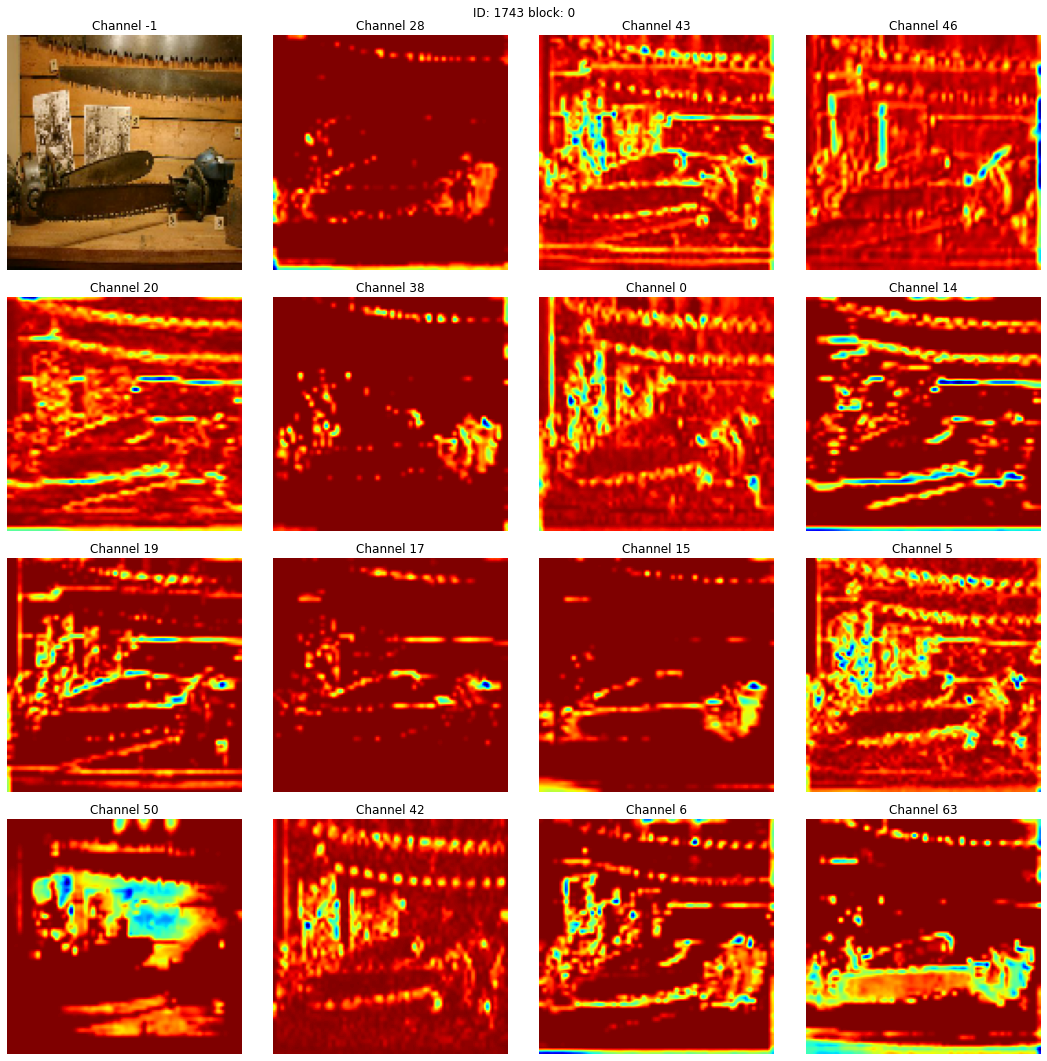

In [10]:
ridx = get_random_id(train_dataset)
plot_visuals(model, train_dataset,
             idx=ridx, block=0, 
             super_impose=False,
             channels=[28],
             include_ori=True,
             channel_seed=None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


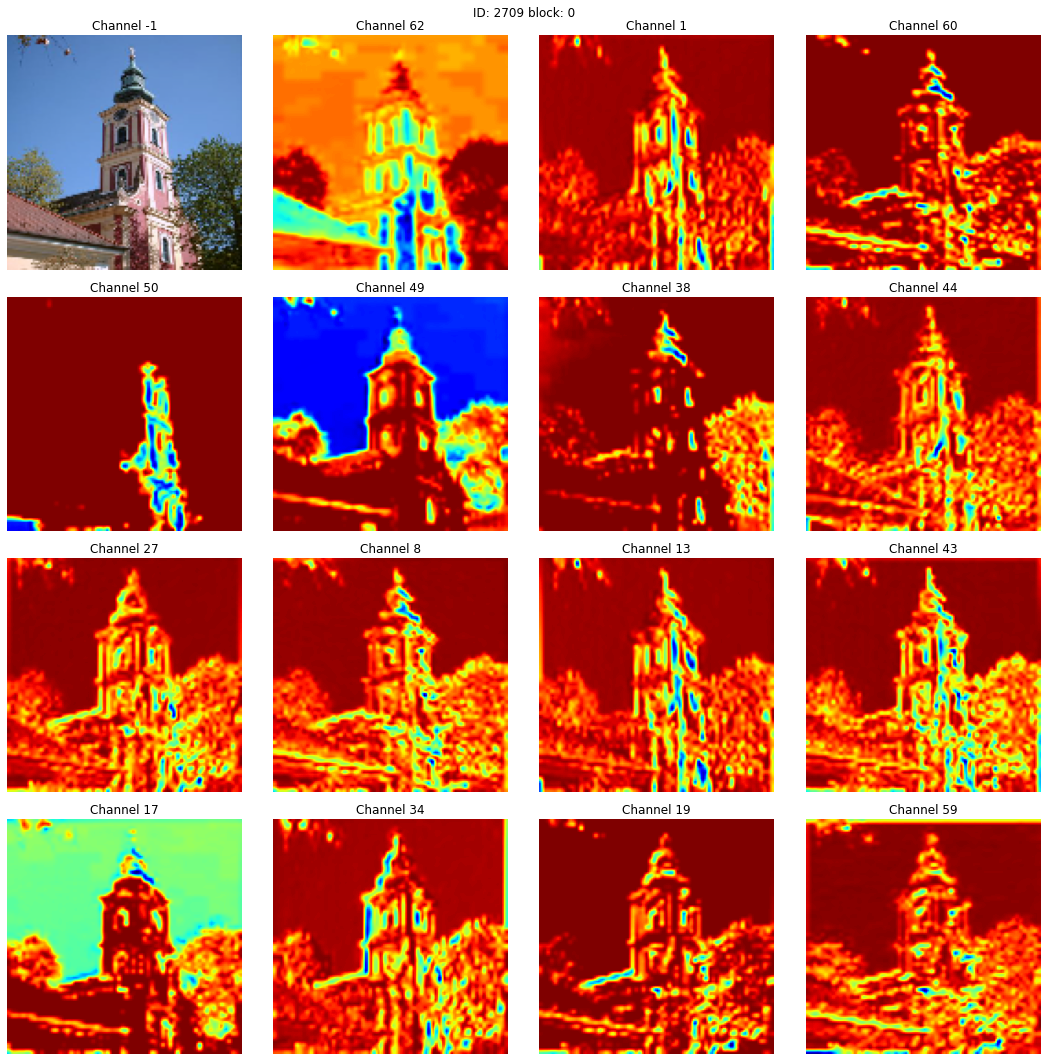

In [11]:
ridx = get_random_id(train_dataset)
plot_visuals(model, train_dataset,
             idx=ridx, block=0, 
             super_impose=False,
#              channels=[28],
             include_ori=True,
             channel_seed=None)